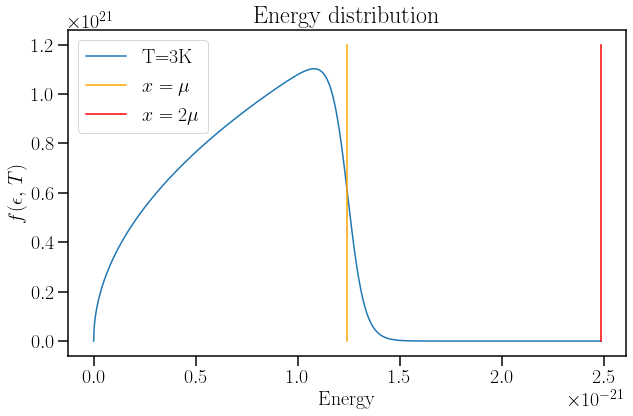

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import quad
import math
from scipy.optimize import minimize_scalar
import time

plt.rcParams.update({
	'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	'axes.labelweight': 'normal',
	'axes.linewidth': 1.5,
	'xtick.major.width': 1.5,
	'xtick.major.size': 10.0,
	'xtick.minor.size': 5.0,
	'ytick.major.width': 1.5,
	'ytick.major.size': 10.0,
	'ytick.minor.size': 5.0,
	'font.size': 30,
    'figure.figsize' : (10,6)})
plt.rcParams.update({'font.size': 20})

kb = 1.380649e-23#J/K
m=40*1.66*1e-27
T=3
mu= 30*kb*T
A=(3.5e+31)/1.0234366462120648 
beta = 1/(kb*T)
n=1
meanTH = (3/(5*0.9945577146403805))*n*mu

def f(epsilon,T):
    beta    = 1/(kb*T)
    num   = A*np.sqrt(epsilon)
    den   = np.exp(beta*(epsilon-mu)) + 1.0
    return num/den

def f3K(epsilon):
    return f(epsilon, 3)

def exp_val(epsilon):
	return epsilon*f(epsilon,3)

def moment_2(epsilon):
	return epsilon*epsilon*f(epsilon,3)

def gauss(x, gmean, gsigma):
    pref = 1/(np.sqrt(2*np.pi)*gsigma)
    return pref*np.exp(-(x-gmean)*(x-gmean)/(2*gsigma*gsigma))

#integral with trapeze
def integral(n):
    nPts=n+1
    nInt=n
    x=np.linspace(0,2*mu,nPts)
    y=np.zeros(len(x))
    for i in range(len(x)):
        denom = np.exp(beta*(x[i]-mu))+1
        y[i]=A*np.sqrt(x[i])/denom
    integrale=0
    for i in range(n):
        integrale += (y[i]+y[i+1])*(x[i+1]-x[i])/2
    return integrale

xfunc = np.linspace(0,2*mu,1000)
yfunc = f(xfunc,3)
plt.plot(xfunc,yfunc, label = "T=3K")
plt.plot([mu, mu],[0,1.2e21], color = "orange", label = "$x = \mu$")
plt.plot([2*mu, 2*mu],[0,1.2e21], color = "red", label = "$x=2\mu$")
plt.xlabel("Energy")
plt.ylabel("$f(\epsilon,\,T)$")
plt.title("Energy distribution")
plt.legend()

# Task 1

Verify that the integral is 1

In [2]:
I = quad(f3K, 0 , 2*mu)
I = I[0]
ExpVal = quad(exp_val, 0, 2*mu)
ExpVal = ExpVal[0]
varPDF = quad(moment_2,0,2*mu)[0]-ExpVal**2

print(  " The integral of f:\t" ,  I 
        ,"\n The exp.value: \t" , ExpVal
        , "\n The theoretical :\t", meanTH
        , "\n The variance  :\t", varPDF)

 The integral of f:	 1.0000000000000002 
 The exp.value: 	 7.496301612517094e-22 
 The theoretical :	 7.496301612517094e-22 
 The variance  :	 1.094468933417454e-43


0.9999999721472871

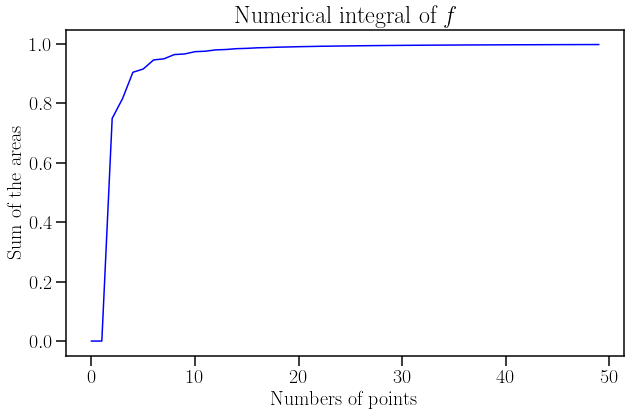

In [3]:
listint = np.zeros(50)
xplot = [*range(len(listint))]

for i in range(len(listint)):
    listint[i] = integral(i)

plt.plot(xplot,listint, color = "blue")
plt.xlabel("Numbers of points")
plt.ylabel("Sum of the areas")
plt.title("Numerical integral of $f$")

integral(int(1e5))

Define the sample generator

In [4]:
def Egenerator(N, Temp):
    xf=np.linspace(0,2*mu,1000)
    yf=f(xf, Temp)
    ymax = np.max(yf)*1.01
    p = 1/((2*mu)*ymax) # Probability that an event is recorded
    Nrand = int(N/(p-0.001)) 
    ok = 0
    
    while ok == 0 :
        x = np.random.rand(Nrand)*(2*mu)
        y = np.random.rand(Nrand)*ymax
        data = x[np.where(y<=f(x,Temp))]
        if len(data)>=N:
            ok = 1
    data = data[:int(N)]
    return data

Just a more complete generator for the graph

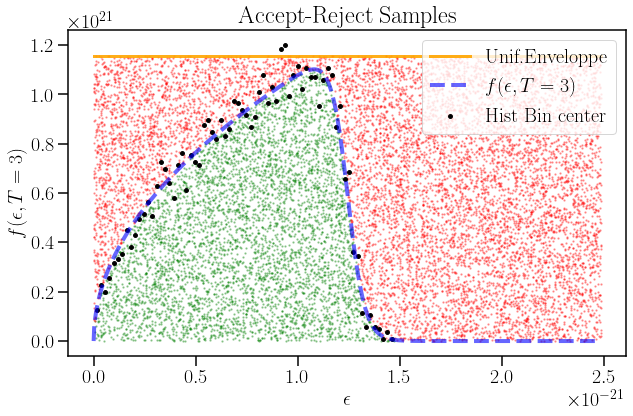

In [5]:
nEvents = 5000
listAccX =[]
listAccY =[]
listRejX =[]
listRejY =[]
interval= (0, 2*mu)
fmax    = np.max(f(np.linspace(*interval,1000),3))*1.05
gen     = np.random.default_rng()
while len(listAccX)<nEvents :
    x       = gen.uniform(*interval)
    y       = gen.uniform(0, fmax)
    if y <= f(x, T):
        listAccX.append(x)
        listAccY.append(y)
    else:
        listRejX.append(x)     
        listRejY.append(y) 

cc, ee = np.histogram(listAccX, density=True, bins = 70)
wi = ee[1]-ee[0]
xC = ee[:-1]+wi/2


xfunc = np.linspace(0,2*mu,1000)
yfunc = f(xfunc,3)

plt.scatter(listAccX,listAccY       , s = 2 , color = "green"   , alpha = 0.3)
plt.scatter(listRejX,listRejY       , s = 2 , color = "red"     , alpha = 0.3)
plt.plot([0,2*mu],[fmax,fmax]   , lw =3 , color = "orange"  , alpha = 0.9, label = "Unif.Enveloppe")
plt.scatter(xC,cc            , s = 15,  color = "black", label = "Hist Bin center")
#plt.fill([1.51e-21,2*mu,2*mu,1.51e-21],[0.7e21,0.7e21,fmax*1.01,fmax*1.01], color = "white", alpha = 0.8)
plt.plot(xfunc,yfunc, "--", color = "blue", alpha = 0.6,lw = 4, label = r"$f(\epsilon, T=3)$")

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$f(\epsilon, T=3)$")
plt.title("Accept-Reject Samples")
plt.legend()

Compute the mean via two ways : manually and numpy

The mean is :  7.491718084001421e-22  The theoretial mean is :  7.496301612517094e-22  The mean computed with numpy is :  7.491675006063456e-22


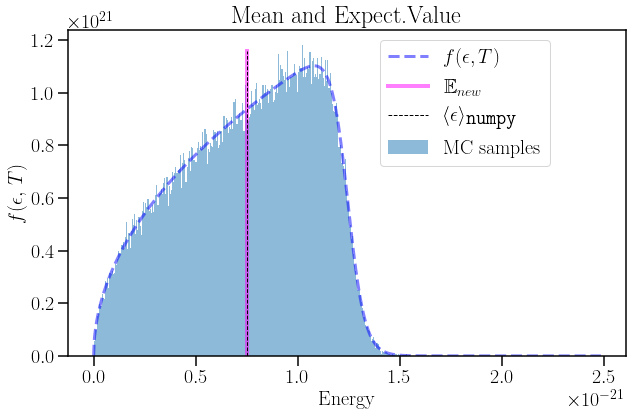

In [6]:
data = Egenerator(1e5, 3)
content,bin_edges, _ = plt.hist(data, density=True, bins = 300, alpha = 0.5, label = "MC samples")
binWidth = (bin_edges[1] - bin_edges[0])
xCoords = bin_edges[:-1] + binWidth/2
#plt.scatter(list(xCoords), np.zeros(len(xCoords)), color = "red", label = "Bin center")

#compute the mean explicitely
mean = np.sum(content*xCoords) *binWidth
m = np.mean(data)


plt.plot(xfunc,yfunc                , "--"  , lw = 3, color = "blue"    , alpha = 0.5   , label = r"$f(\epsilon, T)$")
plt.plot([meanTH, meanTH], [0, fmax]        , lw = 4, color = "magenta" , alpha = 0.5   , label = r"$\mathbb{E}_{new}$")
plt.plot([m, m], [0, fmax]          , '--'  , lw = 1, color = "black"  , alpha = 1     , label = r"$\langle\epsilon\rangle_{\texttt{numpy}}$")

plt.xlabel("Energy")
plt.ylabel("$f(\epsilon,\,T)$")
plt.legend(bbox_to_anchor=[0.54, 0 ,0,1])
plt.title("Mean and Expect.Value")

print("The mean is : " ,mean, " The theoretial mean is : " , ExpVal, " The mean computed with numpy is : ", m)


Compare them, they are the same

In [7]:
print(mean/(kb*T))
print(m/(kb*T))

18.087431065635123
18.087327061556934


The higher moments

In [8]:
v       = np.var(data)
s       = stats.skew(data)
k       = stats.kurtosis(data)
stdev   = np.sqrt(v)
stdev_APP = stdev

print(" variance = ", v , "\n skewness = ", s , "\n kurtosis = ", k, "\n stand dev = ", stdev)

 variance =  1.0920748707449338e-43 
 skewness =  -0.28214650867384583 
 kurtosis =  -0.9175266646206302 
 stand dev =  3.30465561102051e-22


# Task 2

a) Take Nexp = 1 and show the law of large numbers based on the data points you generated.

Now we take the data points we managed to get. They are all distributed according to $f$, with a mean of $18\cdot k_B T$ and a variance $var \approx 1.07 \cdot 10^{-43}$

If we want to show the laws of large numbers, we can show that if we progressively compute the mean for a given number of samples ($N_{exp}=1$), then the average will converge to a number, which should be the mean.

In [9]:
N=1e7
data = Egenerator(N,3)
l = len(data)
steps = 500

listAverage = np.zeros(int(N/steps))
for i in range(int(l/steps)):
    moy = np.mean(data[:i+1])
    listAverage[i] = moy
xMean = np.linspace(0,N,int(l/steps))

[]

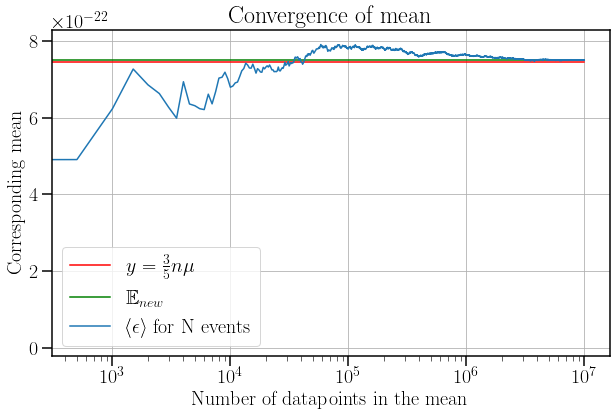

In [10]:
plt.plot([0,N],[meanTH*0.9945,meanTH*0.9945], color = "red", label = r"$y = \frac{3}{5}n\mu$")
plt.plot([0,N],[ExpVal,ExpVal], color = "green", label = r"$\mathbb{E}_{new}$")
plt.plot(xMean, listAverage, label = r"$\langle\epsilon\rangle $ for N events ")

plt.title("Convergence of mean")
plt.xlabel("Number of datapoints in the mean")
plt.ylabel("Corresponding mean")
plt.legend()
plt.grid()
plt.semilogx()

If we take the ratio divided by 18, it converges asymptotically to 1

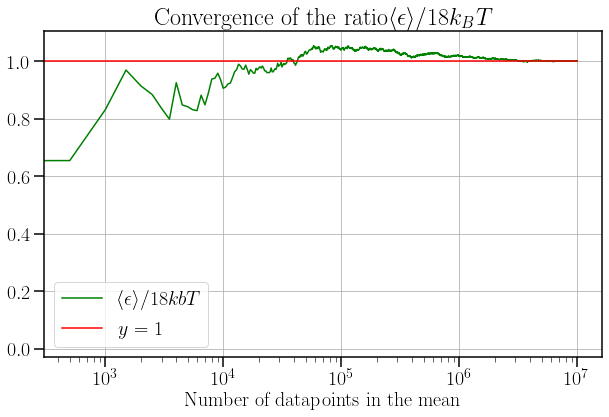

In [11]:
ratio = [listAverage/(ExpVal) for listAverage in listAverage]
plt.plot(xMean, ratio, color = "green", label = r"$\langle\epsilon\rangle/18 kb T$")
plt.plot([0,N],[1,1], color = "red", label = "$y = 1$")
plt.semilogx()
plt.grid()
plt.xlabel("Number of datapoints in the mean")
plt.title("Convergence of the ratio"+r"$\langle\epsilon\rangle/18k_BT$")
plt.legend()


b) Take Nexp >> 1 and show the validity of the central limit theorem for the mean :

We will take for example 2000 experiment and every time, we will compute the mean and put it in a list

In the end, we put it in a histogram and see if it is a Gaussian.

In [12]:
N=1e4
N2 = 500
Nexp = 1e4

k=1
listMean = []
listVar = []
listMean2 = []
listVar2 = []
while k<=Nexp :
    dat     = Egenerator(N,3)
    dat2    = Egenerator(N2,3)

    mean   = np.mean(dat)
    var    = np.var(dat)
    mean2   = np.mean(dat2)
    var2    = np.var(dat2)
    listMean.append(mean)
    listVar.append(var)
    listMean2.append(mean2)
    listVar2.append(var2)
    k = k+1

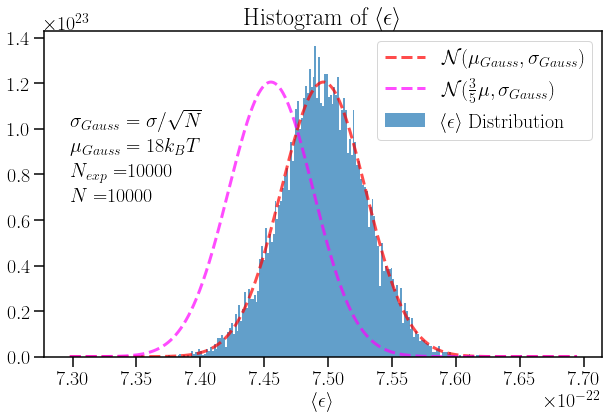

In [13]:
sigmaCLT = np.sqrt(varPDF)/np.sqrt(N)
sigmaCLT2= np.sqrt(varPDF)/np.sqrt(N2)

xplot = np.linspace(ExpVal-6*sigmaCLT, ExpVal+6*sigmaCLT, 1000)
yplot = gauss(xplot, meanTH, sigmaCLT)
yplot2 = gauss(xplot, meanTH*0.994522028, sigmaCLT)

plt.hist(listMean, density=True, bins = 200  , alpha = 0.7      , label = r"$\langle\epsilon\rangle$ Distribution")
plt.plot(xplot,yplot, "--"  , color ="red"  , alpha = 0.7 , lw = 3, label = r"$\mathcal{N}(\mu_{Gauss},\sigma_{Gauss})$")
plt.plot(xplot,yplot2, "--"  , color ="magenta"  , alpha = 0.7 , lw = 3, label = r"$\mathcal{N}(\frac{3}{5}\mu,\sigma_{Gauss})$")
plt.title(r"Histogram of $\langle\epsilon\rangle$" )
plt.xlabel(r"$\langle\epsilon\rangle$")

plt.text(meanTH-6*sigmaCLT, 10.1e22, "$\sigma_{Gauss} = \sigma/\sqrt{N}$"       , horizontalalignment='left')
plt.text(meanTH-6*sigmaCLT, 9e22, "$\mu_{Gauss} = 18k_BT$"                      , horizontalalignment='left')
plt.text(meanTH-6*sigmaCLT, 7.9e22, "$N_{exp}=$"+ str("{:.0f}".format(Nexp))    , horizontalalignment='left')
plt.text(meanTH-6*sigmaCLT, 6.8e22, '$N=$'+ str("{:.0f}".format(N))             , horizontalalignment='left')

plt.legend()

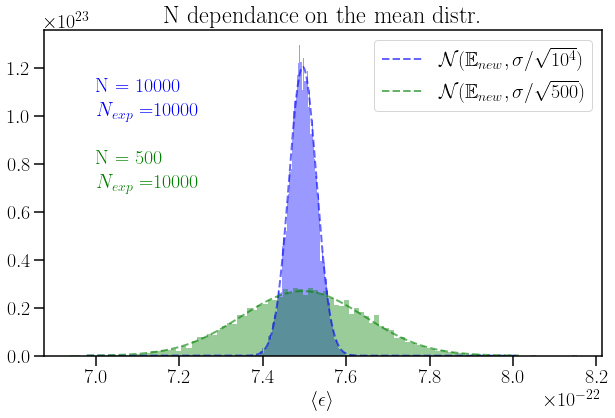

In [14]:
xp = np.linspace(ExpVal-3.5*sigmaCLT2, ExpVal+3.5*sigmaCLT2, 1000)
yp = gauss(xp, meanTH, sigmaCLT)
yp2= gauss(xp, meanTH, sigmaCLT2)

plt.hist(listMean   , density=True, bins = 100, color = "blue" , alpha = 0.4)
plt.hist(listMean2  , density=True, bins = 100, color = "green", alpha = 0.4)

plt.plot(xp,yp  , "--", lw = 2, color = "blue"  , alpha = 0.6, label = r"$\mathcal{N}(\mathbb{E}_{new}, \sigma/\sqrt{10^4})$")
plt.plot(xp,yp2 , "--", lw = 2, color = "green" , alpha = 0.6, label = r"$\mathcal{N}(\mathbb{E}_{new}, \sigma/\sqrt{500})$")

plt.text(7e-22  ,1.1e23 , r"N = "+ str("{:.0f}".format(N))              , color = "blue")
plt.text(7e-22  ,1e23   , r"$N_{exp}= $"+ str("{:.0f}".format(Nexp))    , color = "blue")
plt.text(7e-22  ,0.8e23 , r"N = "+ str("{:.0f}".format(N2))             , color = "green")
plt.text(7e-22  ,0.7e23   , r"$N_{exp}= $"+ str("{:.0f}".format(Nexp))  , color = "green")

plt.xlabel(r"$\langle\epsilon\rangle$")
plt.title("N dependance on the mean distr.")
plt.legend()

We can also normalise the Gaussian

(array([0.00555736, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00555736, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00555736, 0.        ,
        0.        , 0.00555736, 0.00555736, 0.        , 0.        ,
        0.00555736, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00555736, 0.        , 0.        ,
        0.00555736, 0.01111471, 0.00555736, 0.00555736, 0.00555736,
        0.00555736, 0.00555736, 0.02222943, 0.  

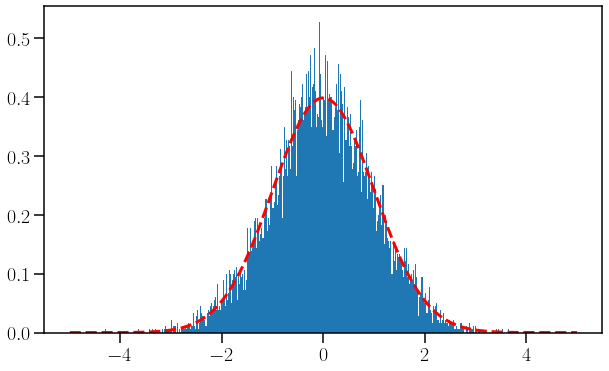

In [15]:
stdDev = np.mean(np.sqrt(listVar))
Z= [(listMean-ExpVal)/(stdDev/np.sqrt(N)) for listMean in listMean]

xTest = np.linspace(-5 , 5 , 1000)
yTest = gauss(xTest, 0, 1)


plt.plot(xTest, yTest, "--", color =  "red", lw = 3)
plt.hist(Z, density = True, bins = 500)

c) Compute the variance of 〈e〉 and compare it with the value you expect.

In [16]:
np.var(listMean)/(sigmaCLT**2)

1.0023345604892546

# Task 3

a) What is the expected p.d.f. for the number of entries per bin?

the number of entries per bin is large => Gaussian with mean $f$. Let's compute the chi2 for one experiment ang generalise later.

Text(0.5, 1.0, 'Comparaison of Poisson and Normal')

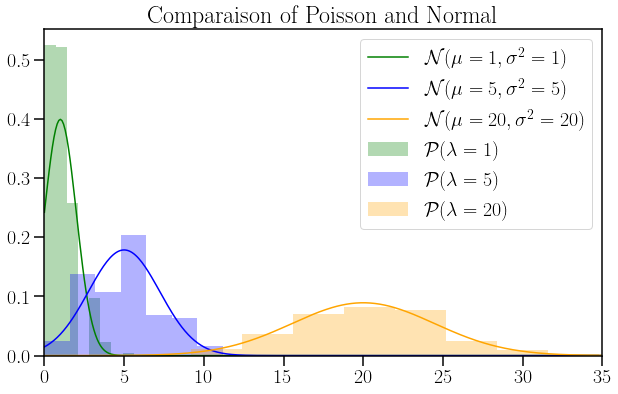

In [17]:
xPoisson = np.linspace(0,40, 400)
plt.hist(np.random.poisson(1,10000) ,alpha = 0.3, color = "green"   , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=1)$")
plt.hist(np.random.poisson(5,10000) ,alpha = 0.3, color = "blue"    , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=5)$")
plt.hist(np.random.poisson(20,10000),alpha = 0.3, color = "orange"  , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=20)$")

plt.plot(xPoisson,gauss(xPoisson,1,np.sqrt(1)), color = "green", label = "$\mathcal{N}(\mu =1, \sigma^2 = 1)$")
plt.plot(xPoisson,gauss(xPoisson,5,np.sqrt(5)), color = "blue", label = "$\mathcal{N}(\mu=5, \sigma^2 = 5)$")
plt.plot(xPoisson,gauss(xPoisson,20,np.sqrt(20)), color = "orange", label = "$\mathcal{N}(\mu=20, \sigma^2 = 20) $")

plt.legend( )
plt.xlim(0,35)
plt.title("Comparaison of Poisson and Normal")

In [18]:
#Expected value of function at bin number i
def ExpectFunc(edges,Temp):
    fi = np.zeros(len(edges)-1)
    for i in range(len(edges)-1):
        fi[i] = quad(f, edges[i], edges[i+1], args = Temp)[0]
    return fi

10.869459203074582


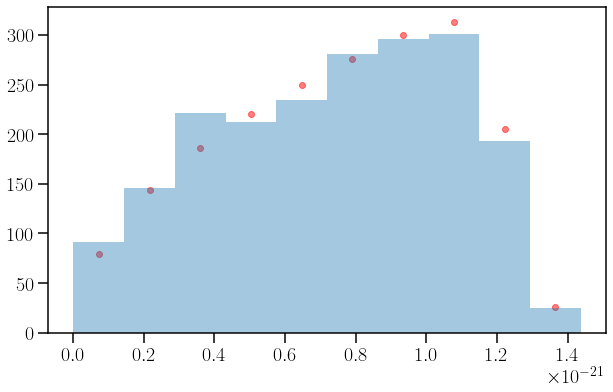

In [19]:
N=int(2000)
d = Egenerator(N,3)
N_bins = 10

content,edges = np.histogram(d, bins=N_bins)
width = edges[1]-edges[0]
xC = edges[:-1]+width/2

plt.hist(d, bins=N_bins, alpha = 0.4)
plt.scatter(xC,N*ExpectFunc(edges,3), color = "red", alpha = 0.5)

chi2 = 0

for i in range(len(content)):
    chi2 = chi2 + np.power((content[i]-N*ExpectFunc(edges,3)[i]),2)/(N*ExpectFunc(edges,3)[i])
    
print(chi2)

Define a function for it

In [20]:
def doChiBin(bin_content,bin_edges):
    width = edges[1]-edges[0]
    xC = edges[:-1]+width/2
    chi2 = 0
    for i in range(len(content)):
        chi2 =chi2 + np.power((content[i]-N*ExpectFunc(edges,3)[i]),2)/(N*ExpectFunc(edges,3)[i])
    return chi2

def doChiBinApprox(bin_content,bin_edges):
    width = edges[1]-edges[0]
    xC = edges[:-1]+width/2
    chi2 = 0
    for i in range(len(content)):
        fj = N*f(xC[i], 3)*width
        chi2 =chi2 + np.power((content[i]-fj),2)/(fj)
    return chi2

In [21]:
Nexp    = int(2000)
N       = int(2000)
nBins   = 10
chiList = np.zeros(Nexp)
chiList_approx = np.zeros(Nexp)


for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList[i] =doChiBin(content, edges)
    chiList_approx[i] =doChiBinApprox(content, edges)
chiList = chiList[chiList< 45]
chiList_approx = chiList_approx[chiList_approx< 45]

(0.0, 45.0)

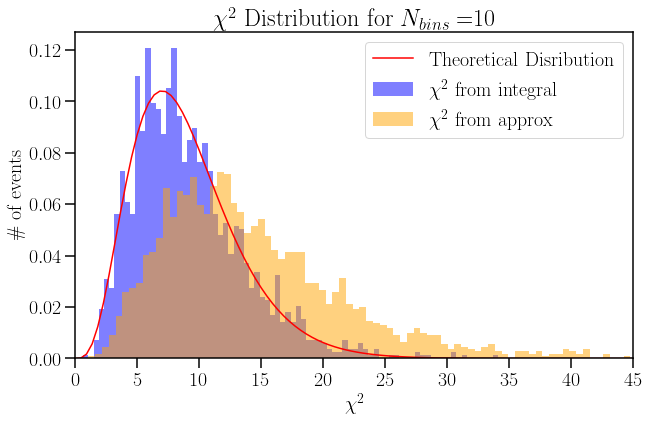

In [22]:
xChi = np.linspace(0,45,100)
yChi = stats.chi2.pdf(xChi, df = nBins-1, scale = 1)

plt.hist(chiList        , density=True, bins = 80, color = "blue"  , alpha = 0.5, label = "$\chi^2$  from integral")
plt.hist(chiList_approx , density=True, bins = 80, color = "orange", alpha = 0.5, label = "$\chi^2$  from approx")
plt.plot(xChi,yChi, color = "red", label = "Theoretical Disribution")

plt.title("$\chi^2$ Distribution for $N_{bins} = $" +str("{:.0f}".format(nBins)))
plt.xlabel("$\chi^2$")
plt.ylabel("\# of events")
plt.legend()
plt.xlim(0,45)



In [23]:
Nexp=2000
N=2000
chiList1 = np.zeros(Nexp)
chiList2 = np.zeros(Nexp)
chiList3 = np.zeros(Nexp)
chiList4 = np.zeros(Nexp)

nBins = 5
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList1[i] =doChiBin(content, edges)
chiList1 = chiList1[chiList1< 50]

nBins = 10
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList2[i] =doChiBin(content, edges)
chiList2 = chiList2[chiList2< 50]

nBins = 15
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList3[i] =doChiBin(content, edges)
chiList3 = chiList3[chiList3< 50]

nBins = 25
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList4[i] =doChiBin(content, edges)
chiList4 = chiList4[chiList4< 50]

Text(0, 0.5, '\\# of events')

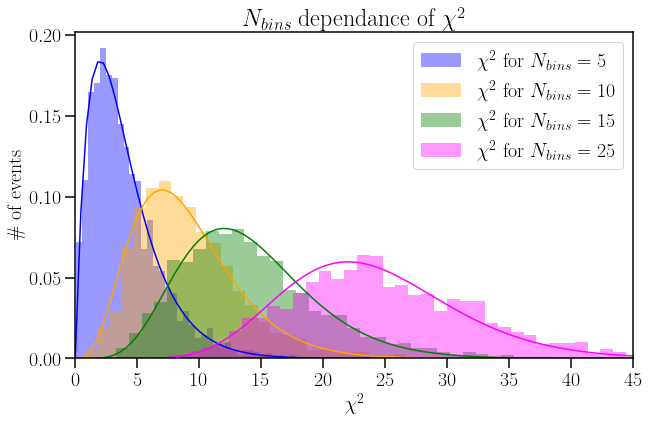

In [24]:
plt.hist(chiList1, density = True, bins = 40, alpha = 0.4, color = "blue"     , label = "$\chi^2$ for $N_{bins}=5$")
plt.hist(chiList2, density = True, bins = 40, alpha = 0.4, color = "orange"   , label = "$\chi^2$ for $N_{bins}=10$")
plt.hist(chiList3, density = True, bins = 40, alpha = 0.4, color = "green"    , label = "$\chi^2$ for $N_{bins}=15$")
plt.hist(chiList4, density = True, bins = 40, alpha = 0.4, color = "magenta"  , label = "$\chi^2$ for $N_{bins}=25$")

xChi = np.linspace(0,45,100)
yChi1 = stats.chi2.pdf(xChi,4)
yChi2 = stats.chi2.pdf(xChi,9)
yChi3 = stats.chi2.pdf(xChi,14)
yChi4 = stats.chi2.pdf(xChi,24)
plt.xlim(0,45)

plt.plot(xChi,yChi1, color = "blue")
plt.plot(xChi,yChi2, color = "orange")
plt.plot(xChi,yChi3, color = "green")
plt.plot(xChi,yChi4, color = "magenta")

plt.legend()
plt.title("$N_{bins}$ dependance of $\chi^2$")
plt.xlabel("$\chi^2$ ")
plt.ylabel("\# of events")

# Task 4

a) Compute the log likelihood ln L(x1, x2, ..., xN | μ) at a given μ. Then, use the maximum
likelihood method to estimate μ and its variance

In [25]:
N=int(1e4)
N2=int(3000)
Nexp=10000
nBins=50
data = Egenerator(N,T)
Ttest=np.linspace(0.5,7,300)
DoComputation = True

In [26]:
def LLH(data, par):
    return -np.log(f(data,par)).sum()

LLH(data,3)

-481311.353936352

In [27]:
listLikeliHood = np.zeros(len(Ttest))
listLikeliHood_Plot = np.zeros(len(Ttest))

for i in range(len(Ttest)):
    l = LLH(data,Ttest[i])
    listLikeliHood[i] = l
    listLikeliHood_Plot[i] = l

Lmin = min(listLikeliHood)
indexLmin = (listLikeliHood.tolist()).index(Lmin)

for i in range(len(Ttest)): #Normalize
    listLikeliHood_Plot[i] -= Lmin

TParam = Ttest[indexLmin]
print (TParam,min(listLikeliHood_Plot))

i1=0
i2=0
for i in range(0,len(Ttest)-1):
    if listLikeliHood_Plot[i]>0.5 and listLikeliHood_Plot[i+1]<0.5:
        i1=i
    if listLikeliHood_Plot[i]<0.5 and listLikeliHood_Plot[i+1]>0.5:
        i2=i

err = (Ttest[i2]-Ttest[i1])/2

print ('The error of the estimation=',err)

3.0869565217391304 0.0
The error of the estimation= 0.10869565217391308


mu =  127.86 +- 4.50
Expected result :  124.94


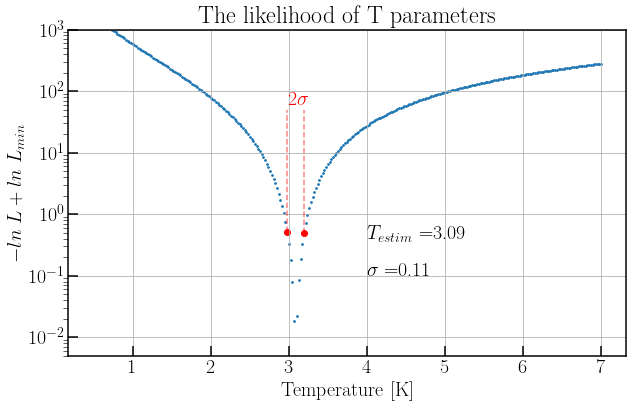

In [28]:
#plt.plot(Ttest,listLikeliHood,'-',lw=3)
plt.scatter(Ttest,listLikeliHood_Plot, s=3)
plt.scatter([TParam-err,TParam+err],[listLikeliHood_Plot[i1],listLikeliHood_Plot[i2]], color = "red")
plt.plot([TParam-err,TParam-err],[listLikeliHood_Plot[i1],50], "--",color = "red", alpha = 0.5)
plt.plot([TParam+err,TParam+err],[listLikeliHood_Plot[i2],50], "--",color = "red", alpha = 0.5)


plt.xlabel("Temperature [K]")
plt.ylabel("$-ln\ L+ln\ L_{min}$")
plt.title("The likelihood of T parameters")

plt.tick_params(direction='in')
plt.text(4,0.4, "$T_{estim} = $"+ str("{:.2f}".format(Ttest[indexLmin])) )
plt.text(4,0.1, "$\sigma = $"+ str("{:.2f}".format(err)) )
plt.text(TParam-0.1,60, "$2\sigma$", color ="red")

plt.semilogy()
plt.grid(True)
plt.ylim(0.005,1000)
print("mu = " , str("{:.2f}".format(30*kb*Ttest[indexLmin]*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : ",  str("{:.2f}".format(1e23*meanTH/((3/5)))))

Same code but with auto minimizing : in the end, it is useless

In [29]:
dat = Egenerator(3e3,3)
#dat = data

minimPar    = minimize_scalar(lambda x: LLH(dat,x),[0.5,7])
errPos      = minimize_scalar(lambda ep :( abs(LLH(dat,ep+minimPar.x)-minimPar.fun-0.5) ) , bounds=(0,1))
errMin      = minimize_scalar(lambda em :( abs(LLH(dat,em+minimPar.x)-minimPar.fun-0.5) ), bounds=(-1,0))
err         = (errPos.x+errMin.x)/2

print("TMin = " , minimPar.x, "error =", err)

TMin =  2.993580475353859 error = 0.20451921316422464


In [30]:
result_LLH_sp   = np.zeros(Nexp)
std_LLH_sp      = np.zeros(Nexp)
result_LLH_sp2  = np.zeros(Nexp)
std_LLH_sp2     = np.zeros(Nexp)

for i in range(Nexp):
    
    dat             = Egenerator(N,3)
    dat2            = Egenerator(N2,3)

    minimPar        = minimize_scalar(lambda x: LLH(dat,x),[0.5,7])
    errPos          = minimize_scalar(lambda ep :( abs(LLH(dat,ep+minimPar.x)-minimPar.fun-0.5) ) , bounds=(0,1))
    errMin          = minimize_scalar(lambda ep :( abs(LLH(dat,-ep+minimPar.x)-minimPar.fun-0.5) ), bounds=(-1,0))
    err             = (abs(errPos.x)+abs(errMin.x))/2

    minimPar2        = minimize_scalar(lambda x: LLH(dat2,x),[0.5,7])
    errPos2          = minimize_scalar(lambda ep :( abs(LLH(dat2,ep+minimPar2.x)-minimPar2.fun-0.5) ) , bounds=(0,1))
    errMin2          = minimize_scalar(lambda ep :( abs(LLH(dat2,-ep+minimPar2.x)-minimPar2.fun-0.5) ), bounds=(-1,0))
    err2             = (abs(errPos2.x)+abs(errMin2.x))/2

    result_LLH_sp[i]= minimPar.x
    std_LLH_sp[i]   = err
    result_LLH_sp2[i]= minimPar2.x
    std_LLH_sp2[i]   = err2


3.102595579284337 3.1008103753881167


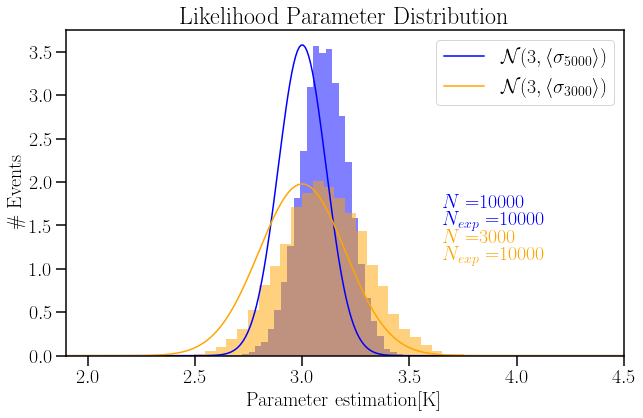

In [31]:
x = np.linspace(1.9,4.5,300)
y = gauss(x,3,np.mean(std_LLH_sp))
y2 = gauss(x,3,np.mean(std_LLH_sp2))

plt.hist(result_LLH_sp  , bins = 30, density=True, color = "blue"   , alpha = 0.5)
plt.hist(result_LLH_sp2 , bins = 30, density=True, color = "orange" , alpha = 0.5)

plt.plot(x,y, color = "blue"    , label = r"$\mathcal{N}(3,\langle\sigma_{5000}\rangle)$")
plt.plot(x,y2, color = "orange" , label = r"$\mathcal{N}(3,\langle\sigma_{3000}\rangle)$")

plt.text(3.65, 1.7, "$N =$"      +str("{:.0f}".format(N))    , color = "blue")
plt.text(3.65, 1.5, "$N_{exp} =$"+str("{:.0f}".format(Nexp)) , color = "blue")
plt.text(3.65, 1.3, "$N =$"      +str("{:.0f}".format(N2))   , color = "orange")
plt.text(3.65, 1.1, "$N_{exp} =$"+str("{:.0f}".format(Nexp)) , color = "orange")

plt.title("Likelihood Parameter Distribution")
plt.xlabel("Parameter estimation[K]")
plt.ylabel("\# Events")
plt.xlim(1.9,4.5)

plt.legend()

print(np.mean(result_LLH_sp), np.mean(result_LLH_sp2))

In [32]:
if(DoComputation):
    result_LLH  = np.zeros(Nexp)
    std_LLH     = np.zeros(Nexp)
    result_LLH2 = np.zeros(Nexp)
    std_LLH2    = np.zeros(Nexp)

    for i in range(Nexp):
        dat = Egenerator(N,T)
        listLikeliHood = np.zeros(len(Ttest))

        for j in range(len(Ttest)):
            l = LLH(dat,Ttest[j])
            listLikeliHood[j] = l

        Lmin = min(listLikeliHood)
        indexLmin = (listLikeliHood.tolist()).index(Lmin)
        TParam = Ttest[indexLmin]
        result_LLH[i] = TParam
        
        i1=0
        i2=0
        for l in range(0,len(Ttest)-1):
            if listLikeliHood[l]>0.5+Lmin and listLikeliHood[l+1]<0.5+Lmin:
                i1=l
            if listLikeliHood[l]<0.5+Lmin and listLikeliHood[l+1]>0.5+Lmin:
                i2=l
        err = (Ttest[i2]-Ttest[i1])/2
        std_LLH[i] = err

    ############
    #Same thing for smaller N 
    ############

    for i in range(Nexp):
        dat = Egenerator(N2,T)
        listLikeliHood = np.zeros(len(Ttest))

        for j in range(len(Ttest)):
            l = LLH(dat,Ttest[j])
            listLikeliHood[j] = l

        Lmin = min(listLikeliHood)
        indexLmin = (listLikeliHood.tolist()).index(Lmin)
        TParam = Ttest[indexLmin]
        result_LLH2[i] = TParam
        
        i1=0
        i2=0
        for l in range(0,len(Ttest)-1):
            if listLikeliHood[l]>0.5+Lmin and listLikeliHood[l+1]<0.5+Lmin:
                i1=l
            if listLikeliHood[l]<0.5+Lmin and listLikeliHood[l+1]>0.5+Lmin:
                i2=l
        err = (Ttest[i2]-Ttest[i1])/2
        std_LLH2[i] = err


Mean of Distr (N = 10000 ) =  3.102971739130435 1.0343239130434783
Mean of Distr (N = 3000 ) =  3.0989391304347826 1.0329797101449276


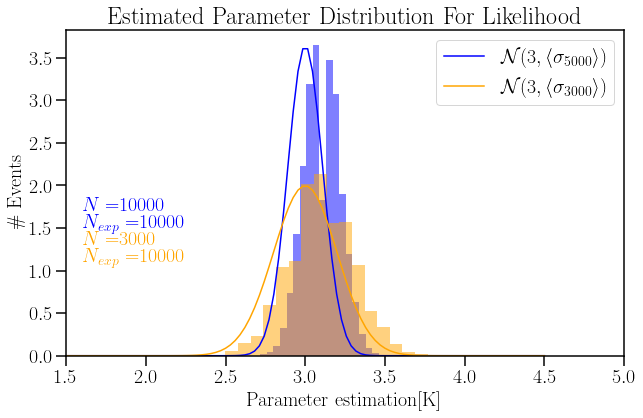

In [33]:
if(DoComputation):
    x = np.linspace(1.5,4.5,100)
    y = gauss(x,3,np.mean(std_LLH))
    y2 = gauss(x,3,np.mean(std_LLH2))

    plt.hist(result_LLH , bins = 20, density=True, color = "blue"    , alpha = 0.5)
    plt.hist(result_LLH2, bins = 20, density=True, color = "orange"  , alpha = 0.5)
    plt.plot(x,y    , color = "blue"    , label = r"$\mathcal{N}(3,\langle\sigma_{5000}\rangle)$")
    plt.plot(x,y2   , color = "orange"  , label = r"$\mathcal{N}(3,\langle\sigma_{3000}\rangle)$")

    plt.text(1.6, 1.7, "$N =$"      +str("{:.0f}".format(N))    , color = "blue")
    plt.text(1.6, 1.5, "$N_{exp} =$"+str("{:.0f}".format(Nexp)) , color = "blue")
    plt.text(1.6, 1.3, "$N =$"      +str("{:.0f}".format(N2))   , color = "orange")
    plt.text(1.6, 1.1, "$N_{exp} =$"+str("{:.0f}".format(Nexp)) , color = "orange")

    plt.title("Estimated Parameter Distribution For Likelihood")
    plt.xlabel("Parameter estimation[K]")
    plt.ylabel("\# Events")
    plt.xlim(1.5,5)
    plt.legend()

    print("Mean of Distr (N = " +str(N) ,") = ",  np.mean(result_LLH),np.mean(result_LLH)/3)
    print("Mean of Distr (N = " +str(N2) ,") = ",  np.mean(result_LLH2),np.mean(result_LLH2)/3)

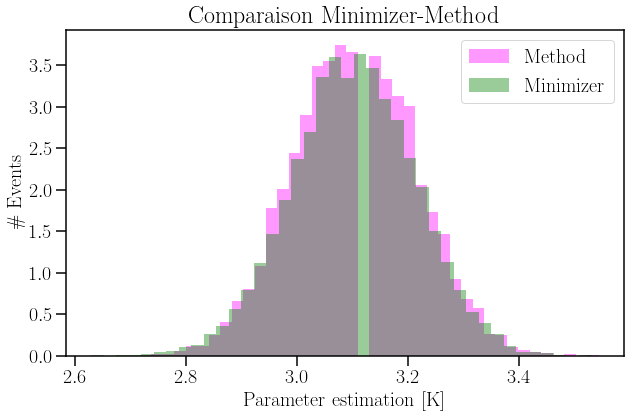

In [70]:
plt.hist(result_LLH     , density=True, color = "magenta", alpha = 0.4, bins = 40, label="Method")
plt.hist(result_LLH_sp  , density=True, color = "green"  , alpha = 0.4, bins = 40, label="Minimizer")

plt.title("Comparaison Minimizer-Method")
plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")
plt.legend()

The p-value of the estimation before is : 24.04%


<ipython-input-35-5d4ac1bcff0f>:2: RuntimeWarning: overflow encountered in exp
  Lmax = np.exp(-LLH(data, Ttest[indexLmin]))


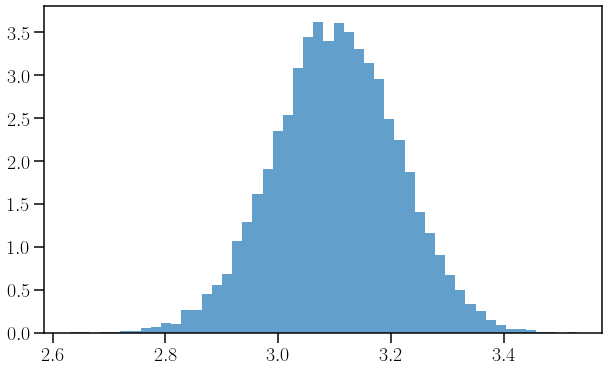

In [35]:
cont,edg,_= plt.hist(result_LLH_sp, bins = 50, density = True, alpha = 0.7)
Lmax = np.exp(-LLH(data, Ttest[indexLmin]))
plt.plot([Lmax,Lmax],[0,30], lw = 3)

w=edg[1]-edg[0]
edgSum = edg[edg<Ttest[indexLmin]][1:]
pVal = np.sum(cont[:len(edgSum)])*w
print("The p-value of the estimation before is : "+str("{:.2f}".format(pVal*100)) + "%")


b) Compute the goodness of fit at various μ and use the least squares method to estimate μ
and its variance.

Let's now define a list of different $\mu$  and for each one of them compute the least squares : 

$$
X = \sum (\dfrac{y(\epsilon)-f(\epsilon, T)}{\sigma})^2
$$

In [36]:
def LeastSquare(data, nBins, params):

    content,edges = np.histogram(data, bins = nBins, density=False)
    width = edges[1]-edges[0]
    xExp = edges[:-1] + width/2
    yerr = np.sqrt(content)
    listX2 =  []

    for j in range(len(params)):
        c=0
        fj = N*ExpectFunc(edges,params[j])
        for i in range(len(content)):
            if(content[i]==0):
                dif=0
            else:
                dif = np.power((content[i]-fj[i])/(yerr[i]),2)
                c+=dif
        listX2.append(c)
    return listX2

def LS(data, nBins, param):

    content,edges = np.histogram(data, bins = nBins, density=False)
    width = edges[1]-edges[0]
    xExp = edges[:-1] + width/2
    yerr = np.sqrt(content)

    chi2 = 0
    fj = N*ExpectFunc(edges,param)
    for i in range(len(content)):
        if(content[i]==0):
            dif=0
        else:
            dif = np.power((content[i]-fj[i])/(yerr[i]),2)
            chi2+=dif
    return chi2

In [37]:
x2List = LeastSquare(data, nBins, Ttest)
jmin = x2List.index(min(x2List))
x2Min = x2List[jmin]
parMin = Ttest[jmin]

for i in range(len(x2List)):
    x2List[i] = x2List[i]-x2Min

j1=0
j2=0
for i in range(len(Ttest)-1):
    if x2List[i]>1 and x2List[i+1]<1:
        j1=i
    if x2List[i]<1 and x2List[i+1]>1:
        j2=i

err = (Ttest[j2]-Ttest[j1])/2


mu =  122.46 +- 4.95
Expected result :  124.26


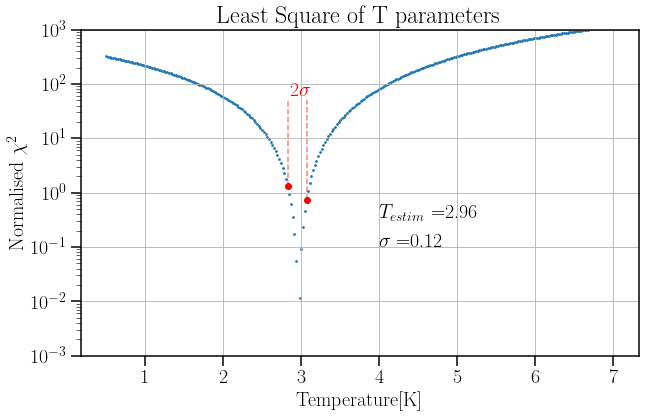

In [38]:
plt.scatter(Ttest, x2List, s=3)
plt.scatter(Ttest[jmin], x2List[jmin], color = "green")
plt.scatter([parMin-err,parMin+err],[x2List[j1],x2List[j2]], color = "red")

plt.xlabel("Temperature[K]")
plt.ylabel("Normalised $\chi^2$")
plt.title("Least Square of T parameters")
plt.semilogy()
plt.ylim(1e-3,1e3)
plt.grid()

plt.plot([parMin-err,parMin-err],[x2List[j1],50], "--",color = "red", alpha = 0.5)
plt.plot([parMin+err,parMin+err],[x2List[j2],50], "--",color = "red", alpha = 0.5)

plt.text(4,0.35, "$T_{estim} = $"+ str("{:.2f}".format(parMin)) )
plt.text(parMin-0.1,60, "$2\sigma$", color ="red")
plt.text(4,0.1, "$\sigma = $"+ str("{:.2f}".format(err)) )


print("mu = " , str("{:.2f}".format(30*kb*parMin*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : ",  str("{:.2f}".format(mu*1e23)))

In [39]:
result_x22 = np.zeros(Nexp)
std_x22    = np.zeros(Nexp)
result_x21 = np.zeros(Nexp)
std_x21    = np.zeros(Nexp)
t           = []

for i in range(Nexp):
    t0 =time.time()
    dat             = Egenerator(N,3)
    minimPar = minimize_scalar(lambda x: LS(dat, nBins, x),[0.5,7])
    errPos   = minimize_scalar(lambda ep :( abs(LS(dat,nBins,ep+minimPar.x)-minimPar.fun-1) ) , bounds=(0,1))
    errMin   = minimize_scalar(lambda ep :( abs(LS(dat,nBins,-ep+minimPar.x)-minimPar.fun-1) ), bounds=(-1,0))
    err      = (errPos.x+errMin.x)/2
    result_x21[i]   = minimPar.x
    std_x21[i]      = err
    t.append(time.time()-t0)
    if(i==20):
        print(" Time for 1 loop is approx:", np.mean(t)
            , "\n Comp is finished in ", np.mean(t)*Nexp, "s"
            , " = " , np.mean(t)*Nexp/60 , "min" )

t           = []
for i in range(Nexp):
    t0 =time.time()
    dat      = Egenerator(N2,3)
    minimPar = minimize_scalar(lambda x: LS(dat, nBins, x),[0.5,7])
    errPos   = minimize_scalar(lambda ep :( abs(LS(dat,nBins,ep+minimPar.x)-minimPar.fun-1) ) , bounds=(0,1))
    errMin   = minimize_scalar(lambda ep :( abs(LS(dat,nBins,-ep+minimPar.x)-minimPar.fun-1) ), bounds=(-1,0))
    err      = (errPos.x+errMin.x)/2
    result_x22[i]   = minimPar.x
    std_x22[i]      = err
    t.append(time.time()-t0)
    if(i==20):
        print(" Time for 1 loop is approx:", np.mean(t)
            , "\n Comp is finished in ", np.mean(t)*Nexp, "s"
            , " = " , np.mean(t)*Nexp/60 , "min" )

 Time for 1 loop is approx: 0.330348775500343 
 Comp is finished in  3303.48775500343 s  =  55.05812925005716 min
 Time for 1 loop is approx: 0.31881189346313477 
 Comp is finished in  3188.1189346313477 s  =  53.135315577189125 min


Mean =  2.9544330787845974 0.9848110262615325
Mean =  2.931854015386697 0.9772846717955658


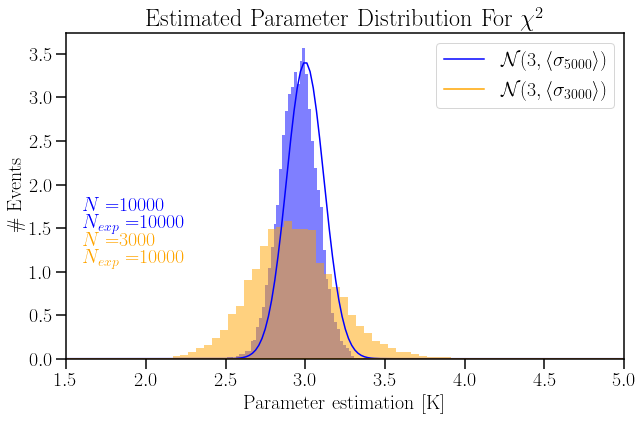

In [40]:
x = np.linspace(1,5,200)
y = gauss(x,3,np.sqrt(np.var(result_x21)))
y2 = gauss(x,3,np.sqrt(np.var(result_x22)))

result_x21 = result_x21[result_x21<10]
result_x22 = result_x22[result_x22<10]

plt.hist(result_x21, bins = 50, density=True, alpha = 0.5 , color = "blue")
plt.hist(result_x22, bins = 50, density=True, alpha = 0.5 , color = "orange")
plt.plot(x,y    , color = "blue"    , label = r"$\mathcal{N}(3,\langle\sigma_{5000}\rangle)$")
plt.plot(x,y2   , color = "orange"  , label = r"$\mathcal{N}(3,\langle\sigma_{3000}\rangle)$")
plt.xlim(1.5,5)

plt.text(1.6, 1.7, "$N =$"      +str("{:.0f}".format(N))    , color = "blue")
plt.text(1.6, 1.5, "$N_{exp} =$"+str("{:.0f}".format(Nexp)) , color = "blue")
plt.text(1.6, 1.3, "$N =$"      +str("{:.0f}".format(N2))   , color = "orange")
plt.text(1.6, 1.1, "$N_{exp} =$"+str("{:.0f}".format(Nexp)) , color = "orange")

plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")
plt.title("Estimated Parameter Distribution For $\chi^2$")
plt.legend()

print("Mean = ", np.mean(result_x21), np.mean(result_x21)/3)
print("Mean = ", np.mean(result_x22), np.mean(result_x22)/3)

In [41]:
if(DoComputation):
    result_x2 = np.zeros(Nexp)
    std_x2 = np.zeros(Nexp)
    t = []

    for i in range(len(result_x2)):
        t0 = time.time()
        dat = Egenerator(N,3)
        ls = LeastSquare(dat, nBins, Ttest)
        
        x2Min = ls[ls.index(min(ls))]
        result_x2[i] = Ttest[ls.index(min(ls))]

        j1=0
        j2=0
        for k in range(len(Ttest)-1):
            if ls[k]>1+x2Min and ls[k+1]<1+x2Min:
                j1=k
            if ls[k]<1+x2Min and ls[k+1]>1+x2Min:
                j2=k
        err = (Ttest[j2]-Ttest[j1])/2
        std_x2[i] = err
        t.append(time.time()-t0)
        if(i==15):
            print(" Time for 1 loop is approx:", np.mean(t)
                , "\n Comp is finished in ", np.mean(t)*Nexp, "s"
                , " = " , np.mean(t)*Nexp/60 , "min" )

 Time for 1 loop is approx: 1.0900997519493103 
 Comp is finished in  10900.997519493103 s  =  181.68329199155173 min


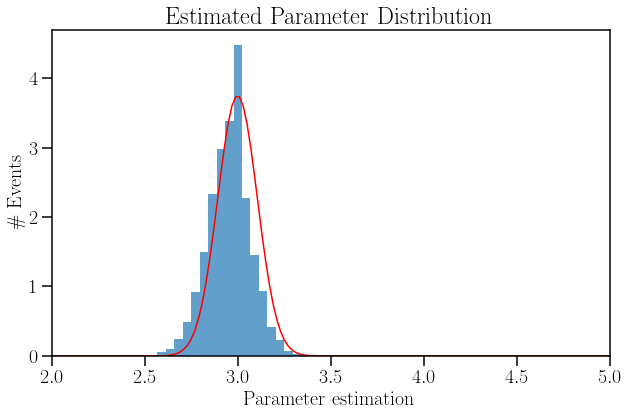

In [76]:
if(DoComputation):
    x = np.linspace(1,5,200)
    y = gauss(x,3,np.mean(abs(std_x2)))

    plt.hist(result_x2, bins = 20, density=True, alpha = 0.7)
    plt.plot(x,y, color = "red"   , label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
    plt.xlim(2,5)

    plt.xlabel("Parameter estimation")
    plt.ylabel("\# Events")
    plt.title("Estimated Parameter Distribution")

    #plt.text(1.6, 3, "$N =$"+str("{:.0f}".format(N)))
    #plt.text(1.6, 2.5, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
    #plt.legend(bbox_to_anchor=(0.45,0.95))

c) The parameter μ can also be estimated by computing the sample mean 〈e〉 of Eq. (1) with
the MC integral. Perform this estimation of μ and its corresponding variance.

We use : (x_i distriuted as f, energy)

$$
E_f(x)= \int_0^{2\mu} x\cdot f(x) dx \approx \dfrac{1}{N}\sum_{i=1}^N h(x_i)
$$

T = 3.02 +- 0.01
mu = 125.13 +- 0.55


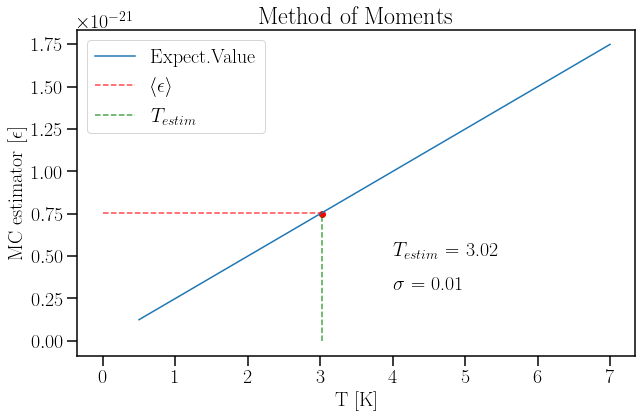

In [43]:
dat     = data
MCest   = (1/N)*np.sum(dat)
MCvar   = (1/N)*np.sum(np.power(dat,2))-np.power(MCest,2)
MCstd   = np.sqrt(MCvar)/np.sqrt(N)

xxx = Ttest
yyy = (3/(5*0.994522028))*30*kb*xxx

estmu   = ((5*0.994522028)/3)*MCest
mustd   = ((5*0.994522028)/3)*MCstd
TMC     = ((5*0.994522028)/(3*30*kb))*MCest
varT    = ((5*0.994522028)/(3*30*kb))*MCstd

print("T = "  +str("{:.2f}".format(TMC))        + " +- " +str("{:.2f}".format(varT)))
print("mu = " +str("{:.2f}".format(estmu*1e23)) + " +- " +str("{:.2f}".format(mustd*1e23)))

plt.plot(xxx,yyy, label = "Expect.Value")
plt.plot([0,TMC],[MCest,MCest], "--"    , color = "red"     , alpha = 0.7, label = r"$\langle\epsilon\rangle$")
plt.scatter(TMC, (3/5)*30*kb*TMC        , color = "red")
plt.plot([TMC,TMC],[0,MCest]    , "--"  , color = "green"   , alpha = 0.7, label = r"$T_{estim}$")

plt.title("Method of Moments")
plt.xlabel("T [K]")
plt.ylabel("MC estimator $[\epsilon]$")


plt.text(4,0.5e-21,"$T_{estim}$ = " + str("{:.2f}".format(TMC)))
plt.text(4,0.3e-21,"$\sigma$ = " + str("{:.2f}".format(varT)))

plt.legend()



In [44]:
result_Mom      = np.zeros(Nexp)
std_Mom         = np.zeros(Nexp)
result_Mom_wr   = np.zeros(Nexp)
std_Mom_wr      = np.zeros(Nexp)
for i in range(Nexp):
    dat     = Egenerator(N,T)
    MCest   = (1/N)*np.sum(dat)
    MCvar   = (1/N)*np.sum(np.power(dat,2))-np.power(MCest,2)
    MCstd   = np.sqrt(MCvar)

    #Redefine parameter !

    TMC     = ((5*0.994522028)/(3*30*kb))*MCest
    varT    = ((5*0.994522028)/(3*30*kb))*MCstd
    TMC_wr     = ((5)/(3*30*kb))*MCest
    varT_wr    = ((5)/(3*30*kb))*MCstd
    result_Mom[i] = TMC
    std_Mom[i] = varT
    result_Mom_wr[i] = TMC_wr
    std_Mom_wr[i] = varT_wr

2.9997799774673504


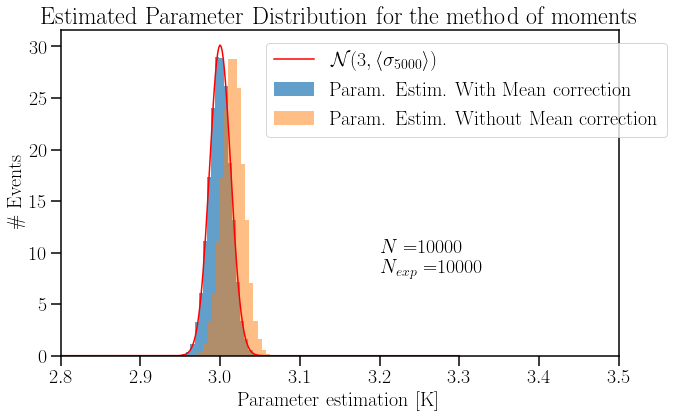

In [77]:
x = np.linspace(2.6,3.3,500)
y = gauss(x,3,np.mean(std_Mom)/np.sqrt(N))

plt.hist(result_Mom      , bins = 20, density=True, alpha = 0.7, label = "Param. Estim. With Mean correction")
plt.hist(result_Mom_wr   , bins = 20, density=True, alpha = 0.5, label = "Param. Estim. Without Mean correction")

plt.plot(x,y,       color = "red"   , label = r"$\mathcal{N}(3,\langle\sigma_{5000}\rangle)$")
plt.xlim(2.8,3.5)

plt.title("Estimated Parameter Distribution for the method of moments")
plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")
plt.text(3.2, 10, "$N =$"+str("{:.0f}".format(N)))
plt.text(3.2, 8, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
plt.legend(bbox_to_anchor=(0.35,0.99))

print(np.mean(result_Mom))

47.7783564815012 47.55434923008778 413.41316318260164


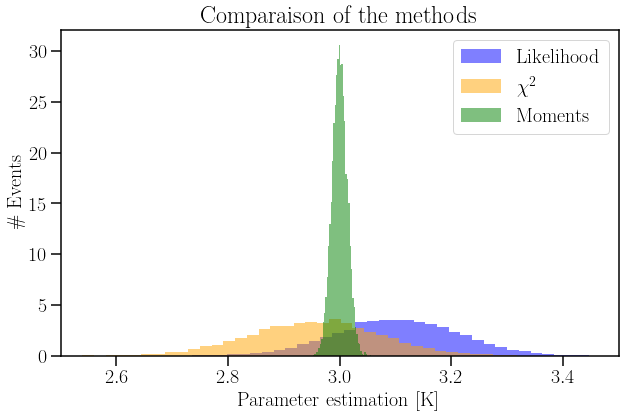

In [46]:
c1,_,_=plt.hist(result_LLH_sp, density=True, color="blue"   , alpha=0.5, bins=43, label="Likelihood")
c2,_,_=plt.hist(result_x21 , density=True, color="orange"  , alpha=0.5, bins=43, label=r"$\chi^2$")
c3,_,_=plt.hist(result_Mom , density=True, color="green"   , alpha=0.5, bins=43, label="Moments")

plt.title("Comparaison of the methods")
plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")

plt.xlim(2.5,3.5)
plt.legend()
print(np.sum(c1),np.sum(c2),np.sum(c3))

# Task 5 

In [47]:
N=1e3
data_1 = np.sort(Egenerator(N,3))  #Generate the data and sort it.
data_2 = np.sort(Egenerator(N,3))
data_conc = np.sort(np.concatenate((data_1, data_2)))

x = np.linspace(0,2*mu,len(data_1))

#print("data_1 :\n{}".format(data_1))
#print(20*'-')
#print("data_2 :\n{}".format(data_2))
#print(20*'-')
#print("data_conc :\n{}".format(data_conc))

In [48]:
# Compute the cumulative function using scipy "percentileofscore"

data_1_cum = [stats.percentileofscore(data_1, i)/100 for i in x]
#print('data_1_cum:\n{}'.format(data_1_cum))
#print(20*'-')

data_2_cum = [stats.percentileofscore(data_2, i)/100 for i in x]
#print('data_2_cum:\n{}'.format(data_2_cum))
#print(20*'-')

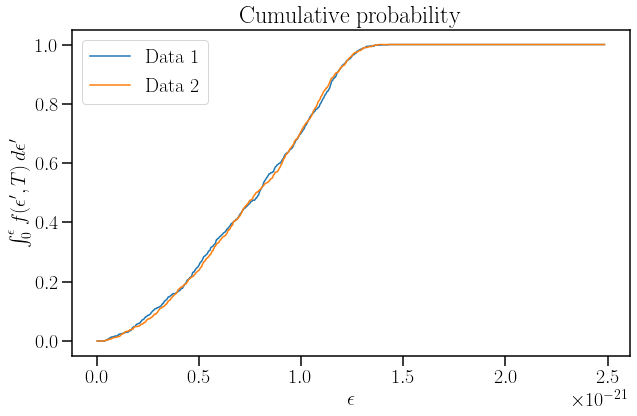

In [49]:
plt.plot(x,data_1_cum, label = "Data 1")
plt.plot(x,data_2_cum, label = "Data 2")

plt.title("Cumulative probability")
plt.xlabel("$\epsilon$")
plt.ylabel("$\int_0^{\epsilon} f(\epsilon',T) \,d\epsilon'$")
plt.legend()


In [50]:
# Compute the (absolute difference) : 

data_diff = np.abs(np.subtract(data_1_cum, data_2_cum))
#print('data_diff:\n{}'.format(data_diff))

# Compute the max difference :
max_diff = max(data_diff)
max_diff

0.02399999999999991

In [51]:
# Trying to use directly the 2-sample Kolmogorov test from scipy.stats:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
# https://stackoverflow.com/questions/39132469/how-to-interpret-scipy-stats-kstest-and-ks-2samp-to-evaluate-fit-of-data-t?rq=1

D_statistics, p_value = stats.ks_2samp(data_1,data_2) #D_statistics is the absolute max distance between the two samples

print('D_stats is :\n{}'.format(D_statistics), '\np_value is:\n{}'.format(p_value))

D_stats is :
0.025 
p_value is:
0.9136894237272155


We see that we get almost the same result using stats.ks.2samp than with our hand-made method (compare D_stats with max_diff)

In [52]:
alpha = [0.20, 0.15, 0.10, 0.05, 0.025, 0.01, 0.005, 0.001]
c_alpha = [1.073, 1.138, 1.224, 1.358, 1.628, 1.731, 1.949]

crit_value = []

for i in range(len(alpha)):
    crit = np.sqrt(-math.log(alpha[i]/2)*1/N)
    crit_value.append(np.round(crit,3))
print(crit_value)

# We then use that the null hypothesis (which is set as default as : "The two samples originate from the same distribution") is REJECTED if D_stats > values from wikipedia (https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)
for i in range(len(alpha)):
    if D_statistics > crit_value[i]:
        print('The null hypothesis is rejected at the level:\n{}'.format(alpha[i]))
    else : 
        print('We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:\n{}'.format(alpha[i]))

[0.048, 0.051, 0.055, 0.061, 0.066, 0.073, 0.077, 0.087]
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.2
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.15
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.1
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.05
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.025
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.01
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.005
We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.001


In [53]:
# Generalizing for Nexp = 100
N=200
N_exp = 1e5
i = 1
max_dist =[]
pList = []

while i <= N_exp :     
    data_1 = np.sort(Egenerator(N,3))
    data_2 = np.sort(Egenerator(N,3))    
    D_stat, p_value = stats.ks_2samp(data_1, data_2)
    max_dist.append(D_stat)    
    pList.append(p_value)
    i = i+1

In [54]:
# We can compare each of the D_stat value (for each exp) with the 95% confidence level (obtained by using the function we defined before):
# We use the percentileofscore function to see how many (in percentage) are below this value :

print('Crit value for alpha = 0.05 is :\n{}'.format(crit_value[3]))
percentile = stats.percentileofscore(max_dist, crit_value[3])

print('There are', percentile, "% of d <= crit_value : which means that in",percentile , "% of the cases, we cannot reject the null hypothesis that the two datasets originate from the same distribution, at confidence level 95%.")

Crit value for alpha = 0.05 is :
0.061
There are 20.555 % of d <= crit_value : which means that in 20.555 % of the cases, we cannot reject the null hypothesis that the two datasets originate from the same distribution, at confidence level 95%.


[]

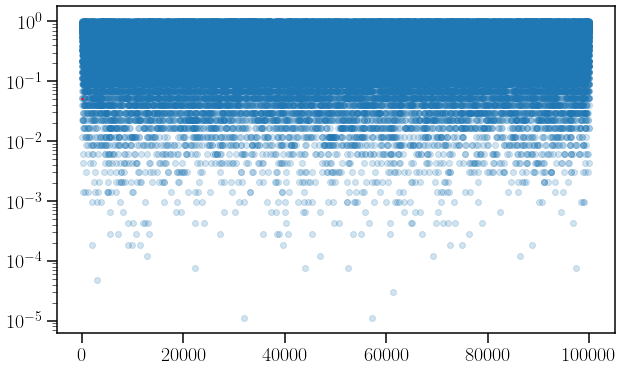

In [79]:
plt.scatter(range(len(pList)),pList, alpha=0.2)
plt.plot([0,100],[0.05,0.05], color = "red")
plt.semilogy()

# Task 6

In [57]:
N           =int(1e4)
N2          =int(3000)
Nexp        = 10000
nBins=50
data6       = Egenerator(N, T)
measured    = np.zeros(len(data6))
uncertainty = 2*kb*T

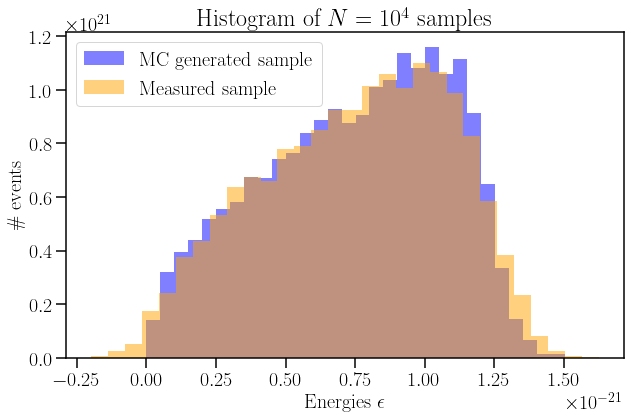

In [58]:
for i in range(len(data6)):
    measured[i] = data6[i] + np.random.normal(0,uncertainty)
mesPos = measured[measured>=0]

plt.hist(data6      , density=True, bins = 30, color = "blue"  , alpha = 0.5, label = "MC generated sample")
plt.hist(measured   , density=True, bins = 30, color = "orange", alpha = 0.5, label = "Measured sample")

plt.title("Histogram of $N=10^4$ samples")
plt.xlabel("Energies $\epsilon$")
plt.ylabel("\# events")
plt.legend()

4.760869565217392 0.0
The error of the estimation= 0.14130434782608692
mu =  197.19 +- 5.85
Expected result :  124.26


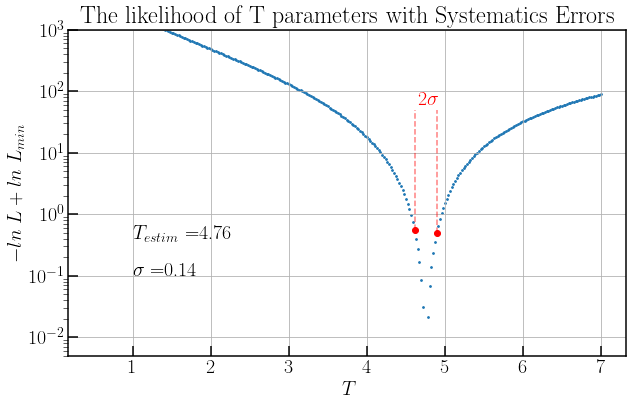

In [59]:
listLikeliHood = np.zeros(len(Ttest))

for i in range(len(Ttest)):
    l = LLH(mesPos,Ttest[i])
    listLikeliHood[i] = l

Lmin = min(listLikeliHood)
indexLmin = (listLikeliHood.tolist()).index(Lmin)

for i in range(len(Ttest)): #Normalize
    listLikeliHood[i] -= Lmin

TParam = Ttest[indexLmin]
print (TParam,min(listLikeliHood))

i1=0
i2=0
for i in range(0,len(Ttest)-1):
    if listLikeliHood[i]>0.5 and listLikeliHood[i+1]<0.5:
        i1=i
    if listLikeliHood[i]<0.5 and listLikeliHood[i+1]>0.5:
        i2=i

err = (Ttest[i2]-Ttest[i1])/2


print ('The error of the estimation=',err)


#plt.plot(Ttest,listLikeliHood,'-',lw=3)
plt.scatter(Ttest,listLikeliHood, s=3)
plt.scatter([TParam-err,TParam+err],[listLikeliHood[i1],listLikeliHood[i2]], color = "red")
plt.plot([TParam-err,TParam-err],[listLikeliHood[i1],50], "--",color = "red", alpha = 0.5)
plt.plot([TParam+err,TParam+err],[listLikeliHood[i2],50], "--",color = "red", alpha = 0.5)


plt.xlabel("$T$")
plt.ylabel("$-ln\ L+ln\ L_{min}$")
plt.title("The likelihood of T parameters with Systematics Errors")

plt.tick_params(direction='in')
plt.text(1,0.4, "$T_{estim} = $"+ str("{:.2f}".format(Ttest[indexLmin])) )
plt.text(1,0.1, "$\sigma = $"   + str("{:.2f}".format(err)) )
plt.text(TParam-0.1,60, "$2\sigma$", color ="red")

plt.semilogy()
plt.grid(True)
plt.ylim(0.005,1000)
print("mu = "               , str("{:.2f}".format(30*kb*Ttest[indexLmin]*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : "  , str("{:.2f}".format(mu*1e23)))

In [60]:
result_sysErr_LLH   = np.zeros(Nexp)
std_sysErr_LLH      = np.zeros(Nexp)
result_sysErr_LLH2  = np.zeros(Nexp)
std_sysErr_LLH2     = np.zeros(Nexp)
for i in range(Nexp):
    
    dat = Egenerator(N,T)
    measured    = np.zeros(len(dat))
    for n in range(len(dat)):
        measured[n] = dat[n] + np.random.normal(0,uncertainty)
    dat = measured[measured>=0]

    dat2 = Egenerator(N2,T)
    measured2    = np.zeros(len(dat2))
    for n in range(len(dat2)):
        measured2[n] = dat2[n] + np.random.normal(0,uncertainty)
    dat2 = measured2[measured2>=0]


    minimPar    = minimize_scalar(lambda x: LLH(dat,x),[0.5,7])
    errPos      = minimize_scalar(lambda ep :( abs(LLH(dat,ep+minimPar.x)-minimPar.fun-0.5) ) , bounds=(0,1))
    errMin      = minimize_scalar(lambda ep :( abs(LLH(dat,-ep+minimPar.x)-minimPar.fun-0.5) ), bounds=(-1,0))
    err         = (abs(errPos.x)+abs(errMin.x))/2

    minimPar2   = minimize_scalar(lambda x: LLH(dat2,x),[0.5,7])
    errPos2     = minimize_scalar(lambda ep :( abs(LLH(dat2,ep+minimPar2.x)-minimPar2.fun-0.5) ) , bounds=(0,1))
    errMin2     = minimize_scalar(lambda ep :( abs(LLH(dat2,-ep+minimPar2.x)-minimPar2.fun-0.5) ), bounds=(-1,0))
    err2        = (abs(errPos2.x)+abs(errMin2.x))/2

    result_sysErr_LLH[i]= minimPar.x
    std_sysErr_LLH[i]   = err
    result_sysErr_LLH2[i]= minimPar2.x
    std_sysErr_LLH[i]   = err2

<ipython-input-1-a24b706617b1>:53: RuntimeWarning: divide by zero encountered in double_scalars
  pref = 1/(np.sqrt(2*np.pi)*gsigma)
<ipython-input-1-a24b706617b1>:54: RuntimeWarning: divide by zero encountered in true_divide
  return pref*np.exp(-(x-gmean)*(x-gmean)/(2*gsigma*gsigma))
<ipython-input-1-a24b706617b1>:54: RuntimeWarning: invalid value encountered in multiply
  return pref*np.exp(-(x-gmean)*(x-gmean)/(2*gsigma*gsigma))


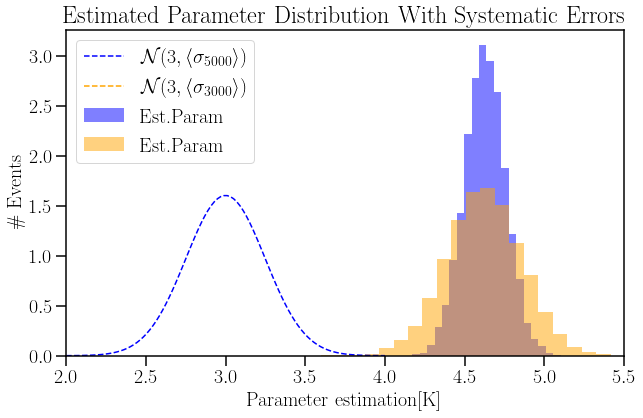

In [61]:
x = np.linspace(2,4,100)
y = gauss(x,3,np.mean(std_sysErr_LLH))
y2 = gauss(x,3,np.mean(std_sysErr_LLH2))

plt.hist(result_sysErr_LLH  , bins = 20, density=True, color = "blue"   , alpha = 0.5, label = "Est.Param")
plt.hist(result_sysErr_LLH2 , bins = 20, density=True, color = "orange" , alpha = 0.5, label = "Est.Param")
plt.plot(x,y    , "--", color = "blue"  , label = r"$\mathcal{N}(3,\langle\sigma_{5000}\rangle)$")
plt.plot(x,y2   , "--", color = "orange", label = r"$\mathcal{N}(3,\langle\sigma_{3000}\rangle)$")
plt.xlim(2,5.5)

plt.title("Estimated Parameter Distribution With Systematic Errors")
plt.xlabel("Parameter estimation[K]")
plt.ylabel("\# Events")
plt.legend()

#plt.text(1.6, 1.6, "$N =$"+str("{:.0f}".format(N)))
#plt.text(1.6, 1.2, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))

b) Least Square

mu =  182.79 +- 4.50
Expected result :  124.26


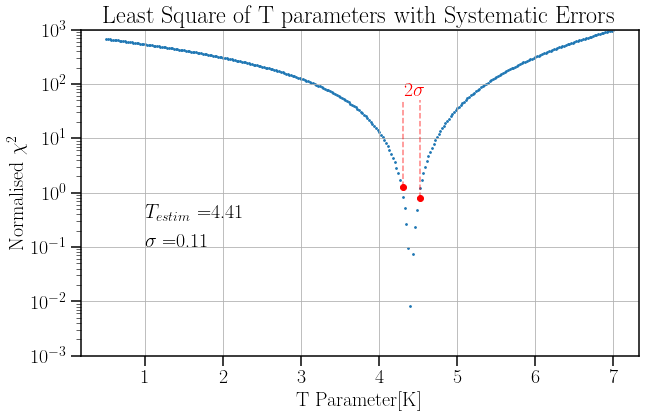

In [62]:
x2List  = LeastSquare(mesPos, nBins, Ttest)
jmin    = x2List.index(min(x2List))
x2Min   = x2List[jmin]
parMin  = Ttest[jmin]

for i in range(len(x2List)):
    x2List[i] = x2List[i]-x2Min

j1=0
j2=0
for i in range(len(Ttest)-1):
    if x2List[i]>1 and x2List[i+1]<1:
        j1=i
    if x2List[i]<1 and x2List[i+1]>1:
        j2=i

err = (Ttest[j2]-Ttest[j1])/2

plt.scatter(Ttest, x2List, s=3)
plt.scatter(Ttest[jmin], x2List[jmin], color = "green")
plt.scatter([parMin-err,parMin+err],[x2List[j1],x2List[j2]], color = "red")

plt.plot([parMin-err,parMin-err],[x2List[j1],50], "--",color = "red", alpha = 0.5)
plt.plot([parMin+err,parMin+err],[x2List[j2],50], "--",color = "red", alpha = 0.5)

plt.text(1,0.35, "$T_{estim} = $"+ str("{:.2f}".format(parMin)) )
plt.text(1,0.1, "$\sigma = $"+ str("{:.2f}".format(err)) )
plt.text(parMin-0.1,60, "$2\sigma$", color ="red")

plt.xlabel("T Parameter[K]")
plt.ylabel("Normalised $\chi^2$")
plt.title("Least Square of T parameters with Systematic Errors")
plt.semilogy()
plt.ylim(1e-3,1e3)
plt.grid()

print("mu = " , str("{:.2f}".format(30*kb*parMin*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : ",  str("{:.2f}".format(mu*1e23)))

In [63]:
result_SysErr_x2= np.zeros(Nexp)
std_SysErr_x2   = np.zeros(Nexp)
t               = []

for i in range(Nexp):
    t0 =time.time()

    dat      = Egenerator(N,3)
    measured    = np.zeros(len(dat))
    for n in range(len(dat)):
        measured[n] = dat[n] + np.random.normal(0,uncertainty)
    dat = measured[measured>=0]
    
    minimPar = minimize_scalar(lambda x: LS(dat, nBins, x),[0.5,10])
    errPos   = minimize_scalar(lambda ep :( abs(LS(dat,nBins,ep+minimPar.x)-minimPar.fun-1) ) , bounds=(0,1))
    errMin   = minimize_scalar(lambda ep :( abs(LS(dat,nBins,-ep+minimPar.x)-minimPar.fun-1) ), bounds=(-1,0))
    err      = (abs(errPos.x)+abs(errMin.x))/2

    result_SysErr_x2[i] = minimPar.x
    std_SysErr_x2[i]    = err
    t.append(time.time()-t0)
    
    if(i==10):
        print(" Time for 1 loop is approx:", np.mean(t)
            , "\n Comp is finished in ", np.mean(t)*Nexp, "s"
            , " = " , np.mean(t)*Nexp/60 , "min" )

 Time for 1 loop is approx: 0.3670920458706943 
 Comp is finished in  3670.9204587069426 s  =  61.18200764511571 min


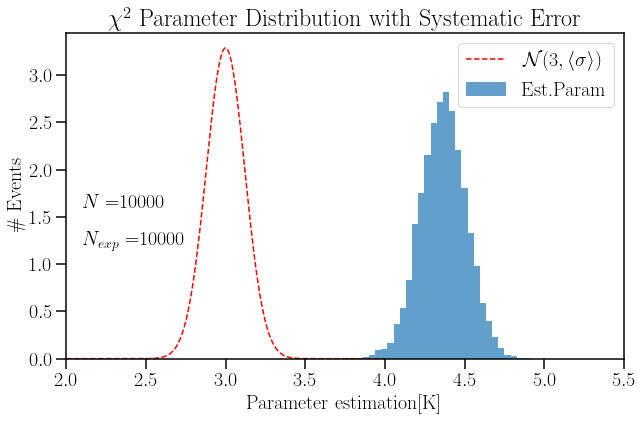

In [64]:
x = np.linspace(2,4,200)
y = gauss(x,3,np.sqrt(np.var(result_SysErr_x2)))
y = gauss(x,3,np.mean(std_SysErr_x2))
plt.hist(result_SysErr_x2, bins = 30, density=True, alpha = 0.7, label = "Est.Param")
plt.plot(x,y, "--", color = "red", label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
plt.xlim(2,5.5)

plt.xlabel("Parameter estimation[K]")
plt.ylabel("\# Events")
plt.text(2.1, 1.6, "$N =$"+str("{:.0f}".format(N)))
plt.text(2.1, 1.2, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
plt.title("$\chi^2$ Parameter Distribution with Systematic Error")
plt.legend()

c) Method of moments

T = 3.01 +- 0.01
mu = 124.47 +- 0.56


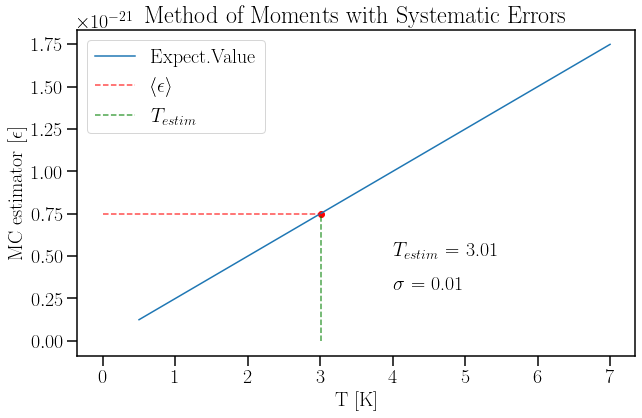

In [65]:
dat     = mesPos
MCest   = (1/N)*np.sum(dat)
MCvar   = (1/N)*np.sum(np.power(dat,2))-np.power(MCest,2)
MCstd   = np.sqrt(MCvar)/np.sqrt(1e4)

xxx = Ttest
yyy = (3/(5*0.994522028))*30*kb*xxx

estmu   = ((5*0.994522028)/3)*MCest
mustd   = ((5*0.994522028)/3)*MCstd
TMC     = ((5*0.994522028)/(3*30*kb))*MCest
varT    = ((5*0.994522028)/(3*30*kb))*MCstd

print("T = "  +str("{:.2f}".format(TMC))        + " +- " +str("{:.2f}".format(varT)))
print("mu = " +str("{:.2f}".format(estmu*1e23)) + " +- " +str("{:.2f}".format(mustd*1e23)))

plt.plot(xxx,yyy, label = "Expect.Value")
plt.plot([0,TMC],[MCest,MCest], "--"    , color = "red"     , alpha = 0.7, label = r"$\langle\epsilon\rangle$")
plt.scatter(TMC, (3/5)*30*kb*TMC        , color = "red")
plt.plot([TMC,TMC],[0,MCest]    , "--"  , color = "green"   , alpha = 0.7, label = r"$T_{estim}$")

plt.title("Method of Moments with Systematic Errors")
plt.xlabel("T [K]")
plt.ylabel("MC estimator $[\epsilon]$")


plt.text(4,0.5e-21,"$T_{estim}$ = " + str("{:.2f}".format(TMC)))
plt.text(4,0.3e-21,"$\sigma$ = " + str("{:.2f}".format(varT)))

plt.legend()

In [66]:
result_Mom_SysErr   = np.zeros(Nexp)
std_Mom_SysErr   = np.zeros(Nexp)

for i in range(Nexp):
    dat = Egenerator(N,T)
    measured    = np.zeros(len(dat))
    for n in range(len(dat)):
        measured[n] = dat[n] + np.random.normal(0,uncertainty)
    dat = measured[measured>=0]
    MCest   = (1/N)*np.sum(dat)
    MCvar   = (1/N)*np.sum(np.power(dat,2))-np.power(MCest,2)
    MCstd   = np.sqrt(MCvar)

    TMC     = ((5*0.994522028)/(3*30*kb))*MCest
    varT    = ((5*0.994522028)/(3*30*kb))*MCstd

    result_Mom_SysErr[i]    = TMC
    std_Mom_SysErr[i]       = varT

3.0012689473802974


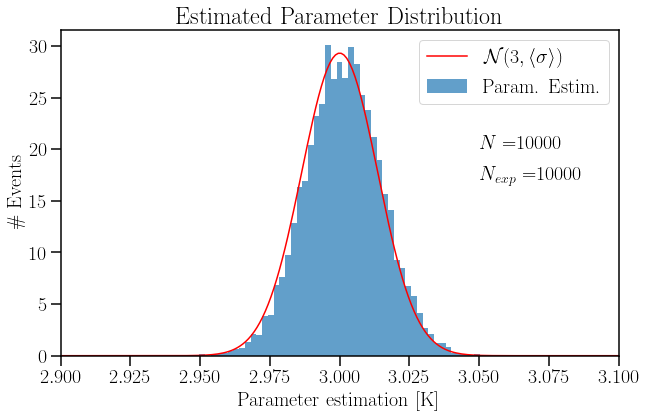

In [67]:
x = np.linspace(2.9,3.1,200)
y = gauss(x,3,np.mean(std_Mom_SysErr)/np.sqrt(N))

plt.hist(result_Mom_SysErr, bins = 50, density=True, alpha = 0.7, label = "Param. Estim.")
plt.plot(x,y,       color = "red"   , label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")

plt.text(3.05, 20, "$N =$"+str("{:.0f}".format(N)))
plt.text(3.05, 17, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))

plt.title("Estimated Parameter Distribution")
plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")
plt.xlim(2.9,3.1)
plt.legend()
print(np.mean(result_Mom_SysErr))

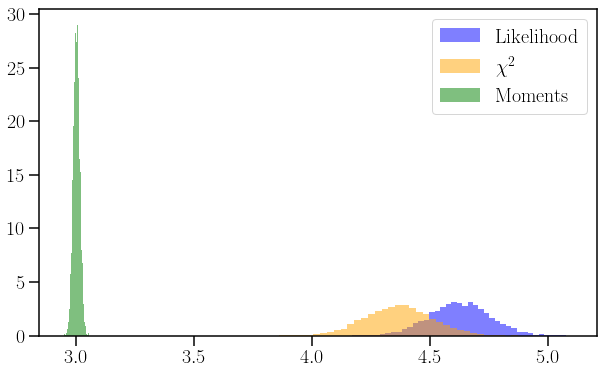

In [68]:
c1,_,_=plt.hist(result_sysErr_LLH, density=True, color="blue"   , alpha=0.5, bins=40, label="Likelihood")
c2,_,_=plt.hist(result_SysErr_x2 , density=True, color="orange" , alpha=0.5, bins=40, label=r"$\chi^2$")
c3,_,_=plt.hist(result_Mom_SysErr ,density=True, color="green"  , alpha=0.5, bins=40, label="Moments")
plt.legend()